### Imports and Helper Functions

In [1]:
import sys
import numpy as np
import functools
from difflib import SequenceMatcher
import nltk
#nltk.download('averaged_perceptron_tagger')

import os
#import dtale
#import dtale.app as dtale_app
#dtale_app.JUPYTER_SERVER_PROXY = True
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config
config_info = {
  "canalyst_api_key": "",
  "s3_access_key_id": "",
  "s3_secret_key": "",
  "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}
config = Config(config=config_info)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
    


A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3_id' and 
'canalyst_s3_key' with those values, respectively. If using a 
Jupyter Notebook, stop and restart the notebook for the changes to 
take effect. If using a Python/iPython session, quit the current 
session and start a new one.


## Drive many read-across models from one Q4 result:
### Goldman Sachs comp ratio vs SF US, PIPR US, EVR US
### TLDR: the simple read-across isn't so simple!  <li>Low R-squareds <li>Bumps in comp ratio already assumed in two cases

In [2]:
canalyst_search = cd.Search(config)
df = canalyst_search.search_time_series(ticker='GS US',
                     time_series_description='compensation')[['ticker','time_series_description','time_series_name']]
df

Building search index...
No.of.unique tickers:  1
No.of.unique time series:  7


,ticker,time_series_description,time_series_name
260562,GS US,"Y/Y change in Compensation per employee, %",z_JAJJLJ0162_MO_OS_YYchangeinCompensationperemployee
260712,GS US,Share-based compensation,z_JAJJLJ0162_MO_CCFS_sharebasedcompensation
260769,GS US,Share-based compensation,MO_CFS_SBC
260561,GS US,"Compensation per employee - implied, $",z_JAJJLJ0162_MO_OS_Compensationperemployeeimplied
260624,GS US,Compensation and benefits,z_JAJJLJ0162_MO_IS_compensationandbenefits
260609,GS US,"Compensation Margin, %",MO_MA_Compensation
260644,GS US,Compensation,MO_RIS_Compensation


## Drive a series of target companies with GS 4q results
### First, instantiate a target company ModelSet

In [3]:
tickers = ["SF US","PIPR US","EVR US"]
target_model_set = cd.ModelSet(ticker_list=tickers, config=config,allow_nulls = True) 

Please instantiate ModelSet with a list of tickers, even a list of one.


### Next, instantiate the GS ModelSet
#### Use the MRQ function to check that it is updated for Q4 2021

In [16]:
ticker = "GS US"
gs_model_set = cd.ModelSet(ticker_list=[ticker], config=config) 
gs_model_set.models[ticker].mrq()

,period_name,period_end_date
0,Q4-2021,2021-12-31


### For initial comparison, instantiate the MS ModelSet

In [17]:
ticker = "MS US"
ms_model_set = cd.ModelSet(ticker_list=[ticker], config=config) 
ms_model_set.models[ticker].mrq()

,period_name,period_end_date
0,Q4-2021,2021-12-31


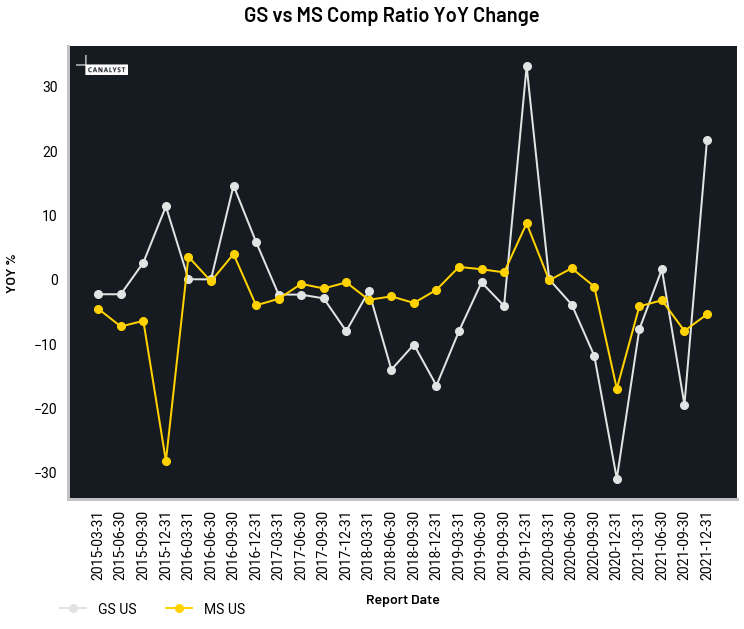

In [20]:
gs_comp = gs_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='MO_MA_Compensation')[['ticker','time_series_name','period_end_date','value']]
gs_comp['value'] = gs_comp['value'].pct_change(4)*100
ms_comp = ms_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='MO_MA_Compensation')[['ticker','time_series_name','period_end_date','value']]
ms_comp['value'] = ms_comp['value'].pct_change(4)*100
df = pd.merge(gs_comp,ms_comp,how='inner',left_on='period_end_date',right_on='period_end_date')[['period_end_date','value_x','value_y']].dropna()
p = cd.Chart(df['period_end_date'],df[["value_x", "value_y"]],["GS US", "MS US"], [["Report Date", "YOY %"]], title="GS vs MS Comp Ratio YoY Change")
p.show()

### The simple correlation between MS and GS comp over time is very low: .23

In [22]:
column_1 = df["value_x"]
column_2 = df["value_y"]
column_1.corr(column_2)

0.23693551632429138

### Now we can run regressions to carry the analysis to names which have not yet reported: 
#### GS against our three target tickers
#### (this will be a single function call in future Candas)


In [5]:
import statsmodels.formula.api as smf

df_gs_ts = gs_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='MO_MA_Compensation')[['ticker','time_series_name','period_end_date','value']].head(-1)

df_target_ts = target_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='MO_MA_Compensation')[['ticker','time_series_name','period_end_date','value']]

gs_pred = gs_model_set.model_frame(
                      period_duration_type='fiscal_quarter',
                      is_historical=True,
                      time_series_name='MO_MA_Compensation')[['ticker','time_series_name','period_end_date','value']]
gs_pred['value'] = gs_pred['value'].pct_change(4)*100

new_gs_value = gs_pred.tail(1).iloc[0]['value']

dict_models = {}
dict_rsquareds = {}
list_df = []

df_params = []
df_params.append(["ticker",
                "period_name",
                "time_series_name",
                "time_series_description",
                "value",
                "new_value",
                "period_end_date"])
    
df_gs_ts['value'] = df_gs_ts['value'].pct_change(4)*100

for ticker in tickers:
    
    df_target = df_target_ts.loc[df_target_ts['ticker']==ticker]
    df_target['old_value']=df_target['value']
    df_target['value'] = df_target['value'].pct_change(4)*100
    
    df = pd.merge(df_gs_ts,df_target,how='inner',left_on='period_end_date',right_on='period_end_date')[['period_end_date','value_x','value_y']].dropna()#.tail(8)
    
    m_test1 = df['value_x'].mean()
    m_test2 = df['value_y'].mean()
    if m_test1 > m_test2:
        formula_string = 'value_y ~ value_x'
    else:
        formula_string = 'value_x ~ value_y'
    mod = smf.ols(formula=formula_string, data=df)
    res = mod.fit()
    dict_models[ticker]=res
    dict_rsquareds[ticker]=res.rsquared
    
    intercept = res.params[0]
    beta = res.params[1]
    new_gs_value = 29
    y = beta*new_gs_value + intercept
    
    year_old_value = df_target.tail(3).iloc[0]['old_value']
    
    new_value = (1+float(y/100))*float(year_old_value)
    
    df_target_fwd = target_model_set.model_frame(ticker=ticker,
                      period_duration_type='fiscal_quarter',
                      is_historical=False,
                      time_series_name='MO_MA_Compensation')[['ticker','time_series_name','period_end_date','value']]
    current_forecast = df_target_fwd.head(1).iloc[0]['value']
    
    df_params.append([ticker,
                    'Q4-2021',
                    'MO_MA_Compensation',
                    '',
                    current_forecast,
                    str(new_value),
                    '2021-12-30'])
    


### Similar to MS / GS, the R squareds are very low

In [6]:
rsq = pd.DataFrame.from_dict(dict_rsquareds,orient='index')
rsq.columns = ['R Squared']
rsq

,R Squared
SF US,0.09150
PIPR US,0.00420
EVR US,0.05093


### The plotted fit for EVR YoY Comp Ratio growth shows why - it is a highly variable series

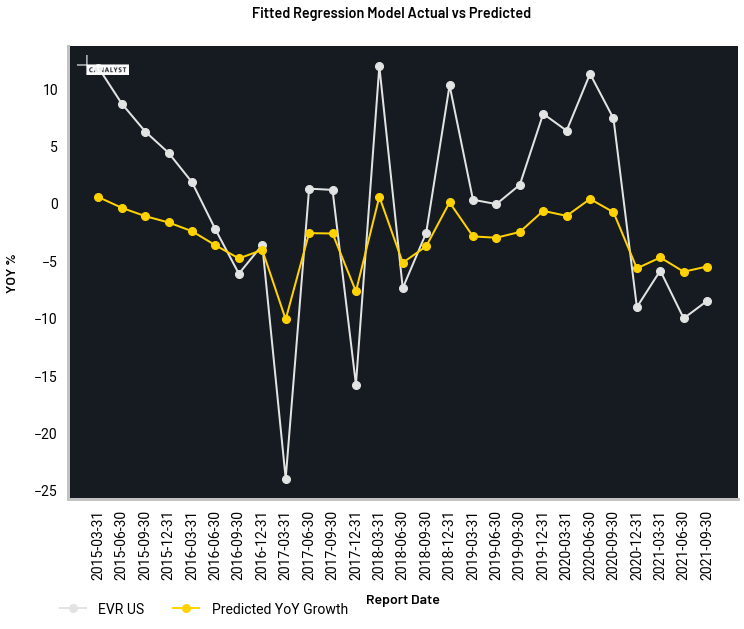

In [8]:
%matplotlib inline
df['predictions']=res.predict()
p = cd.Chart(df['period_end_date'],df[["value_y", "predictions"]],["EVR US", "Predicted YoY Growth"], [["Report Date", "YOY %"]], title="Fitted Regression Model Actual vs Predicted")
p.show()


### GS Compensation Ratio Year over Year growth is also highly variable

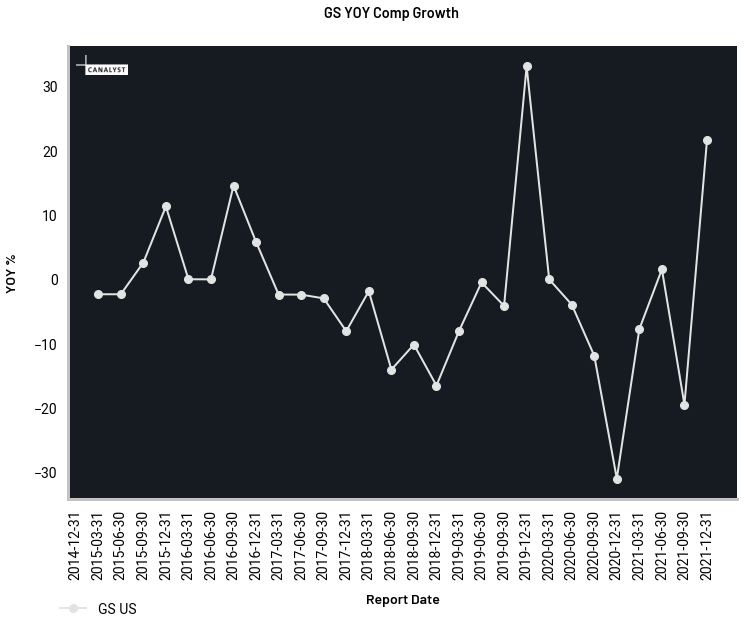

In [9]:
%matplotlib inline
p = cd.Chart(gs_pred['period_end_date'],gs_pred[["value"]],["GS US"], [["Report Date", "YOY %"]], title="GS YOY Comp Growth")
p.show()

### Set the Comp value in our target models to our forecasted numbers
#### Use the fit() function in the ModelSet object target_model_set

In [10]:
df = pd.DataFrame(df_params)
df.columns = df.iloc[0] 
df = df[1:]
df

,ticker,period_name,time_series_name,time_series_description,value,new_value,period_end_date
1,SF US,Q4-2021,MO_MA_Compensation,,57.00000,67.18928152875357,2021-12-30
2,PIPR US,Q4-2021,MO_MA_Compensation,,66.00000,64.76531016356438,2021-12-30
3,EVR US,Q4-2021,MO_MA_Compensation,,66.00000,63.079460432786824,2021-12-30


### We need to specify a return series ... so let's search for "earnings per share"

In [11]:
target_model_set.model_frame('earnings per share',mrq=True)['time_series_name'].unique()

array(['MO_RIS_EPS_WAB', 'MO_RIS_EPS_WAD', 'MO_RIS_EPS_WAD_Adj',
       'z_JMSQQY0110_MO_RIS_consensusestimatesadjustedearningspersharewad',
       'z_NFB5P70127_MO_RIS_consensusestimatesadjustedearningspersharewad',
       'z_MWRR9U0195_MO_RIS_consensusestimatesadjustedearningspersharewad'],
      dtype=object)

### Given eps return series (we pick MO_RIS_EPS_WAD), let's run our scenario engine

In [12]:
return_series = "MO_RIS_EPS_WAD"
dicts_output=target_model_set.fit(df,return_series)

EVR US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/MWRR9U0195/equity-models/Q3-2021.21/scenarios/w8HQfAZgVve1MyleA2Wsog/
PIPR US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/NFB5P70127/equity-models/Q3-2021.25/scenarios/QDS_cLdFW_adJRVBZbm7Dg/
SF US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/JMSQQY0110/equity-models/Q3-2021.24/scenarios/sgKqLNK_WBm_h6YrVDAROA/


### The output is highly variable:<li>SF shows a huge earnings hit<li>PIPR shows a benefit<li>EVR also shows a benefit

In [13]:
for ticker in tickers:
    display(dicts_output[ticker].head(1))

,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,SF US,Q4-2021,MO_RIS_EPS_WAD,Earnings Per Share - WAD,1.65848,0.9083265792,0.54769


,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,PIPR US,Q4-2021,MO_RIS_EPS_WAD,Earnings Per Share - WAD,4.27788,4.578746398,1.07033


,ticker,period_name,time_series_name,time_series_description,default,scenario,diff
0,EVR US,Q4-2021,MO_RIS_EPS_WAD,Earnings Per Share - WAD,2.52591,2.9063726844,1.15062
